# Entrenamiento de Modelos - Alke Wallet

Este notebook se enfoca en el entrenamiento y validación de modelos de clasificación para el proyecto de evaluación crediticia automática de Alke Wallet.

## Objetivo

- Entrenar diferentes modelos de clasificación
- Aplicar validación cruzada para evaluar el rendimiento
- Ajustar hiperparámetros para mejorar el rendimiento
- Seleccionar el mejor modelo para la implementación

## 1. Importación de Bibliotecas

In [1]:
# Bibliotecas básicas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Bibliotecas para modelado y evaluación
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV, learning_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

# Para guardar y cargar modelos
import joblib
import os

# Importar módulos personalizados
import sys
sys.path.append('..')
from src.models import train_model, optimize_hyperparameters, save_model, plot_confusion_matrix, plot_feature_importance

# Configuración para visualizaciones
%matplotlib inline
plt.style.use('seaborn-whitegrid')
sns.set(style='whitegrid')

C:\Users\etien\AppData\Local\Temp\ipykernel_23060\2071457801.py:28: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


## 2. Carga de Datos Preprocesados

In [2]:
# Cargar los datos preprocesados
try:
    X_train_processed = np.load('../data/X_train_processed.npy')
    X_test_processed = np.load('../data/X_test_processed.npy')
    y_train = np.load('../data/y_train.npy')
    y_test = np.load('../data/y_test.npy')
    feature_names = np.load('../models/feature_names.npy')
    
    print(f"X_train_processed shape: {X_train_processed.shape}")
    print(f"X_test_processed shape: {X_test_processed.shape}")
    print(f"y_train shape: {y_train.shape}")
    print(f"y_test shape: {y_test.shape}")
    print(f"Número de características: {len(feature_names)}")
except FileNotFoundError:
    print("No se encontraron los datos preprocesados. Por favor, ejecute primero el notebook de preprocesamiento.")

X_train_processed shape: (800, 13)
X_test_processed shape: (200, 13)
y_train shape: (800,)
y_test shape: (200,)
Número de características: 13


## 3. Entrenamiento de Modelos Base

Entrenamos varios modelos de clasificación con sus configuraciones predeterminadas para tener una comparación inicial.

In [3]:
# Definir modelos a entrenar
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier()
}

# Definir validación cruzada
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Métricas a evaluar
metrics = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

# Diccionario para almacenar resultados
cv_results = {model_name: {} for model_name in models.keys()}

# Entrenar y evaluar modelos con validación cruzada
for model_name, model in models.items():
    print(f"Entrenando {model_name}...")
    
    for metric_name, metric in metrics.items():
        scores = cross_val_score(model, X_train_processed, y_train, cv=cv, scoring=metric)
        cv_results[model_name][metric_name] = scores
        print(f"  {metric_name}: {scores.mean():.4f} ± {scores.std():.4f}")
    
    # Entrenar el modelo en todo el conjunto de entrenamiento
    model.fit(X_train_processed, y_train)
    
    # Guardar el modelo para su uso posterior
    models[model_name] = model

Entrenando Logistic Regression...
  accuracy: 0.9263 ± 0.0092
  precision: 0.9522 ± 0.0142
  recall: 0.9643 ± 0.0134
  f1: 0.9580 ± 0.0051
  roc_auc: 0.9675 ± 0.0127
Entrenando Decision Tree...
  accuracy: 0.8925 ± 0.0108
  precision: 0.9324 ± 0.0081
  recall: 0.9456 ± 0.0186
  f1: 0.9388 ± 0.0065
  roc_auc: 0.7364 ± 0.0274
Entrenando Random Forest...
  accuracy: 0.9088 ± 0.0085
  accuracy: 0.9088 ± 0.0085
  precision: 0.9161 ± 0.0096
  precision: 0.9161 ± 0.0096
  recall: 0.9857 ± 0.0078
  recall: 0.9857 ± 0.0078
  f1: 0.9496 ± 0.0049
  f1: 0.9496 ± 0.0049
  roc_auc: 0.9349 ± 0.0244
Entrenando Gradient Boosting...
  roc_auc: 0.9349 ± 0.0244
Entrenando Gradient Boosting...
  accuracy: 0.9112 ± 0.0108
  accuracy: 0.9112 ± 0.0108
  precision: 0.9411 ± 0.0104
  precision: 0.9411 ± 0.0104
  recall: 0.9585 ± 0.0122
  recall: 0.9585 ± 0.0122
  f1: 0.9496 ± 0.0060
  f1: 0.9496 ± 0.0060
  roc_auc: 0.9413 ± 0.0142
Entrenando SVM...
  roc_auc: 0.9413 ± 0.0142
Entrenando SVM...
  accuracy: 0.9012

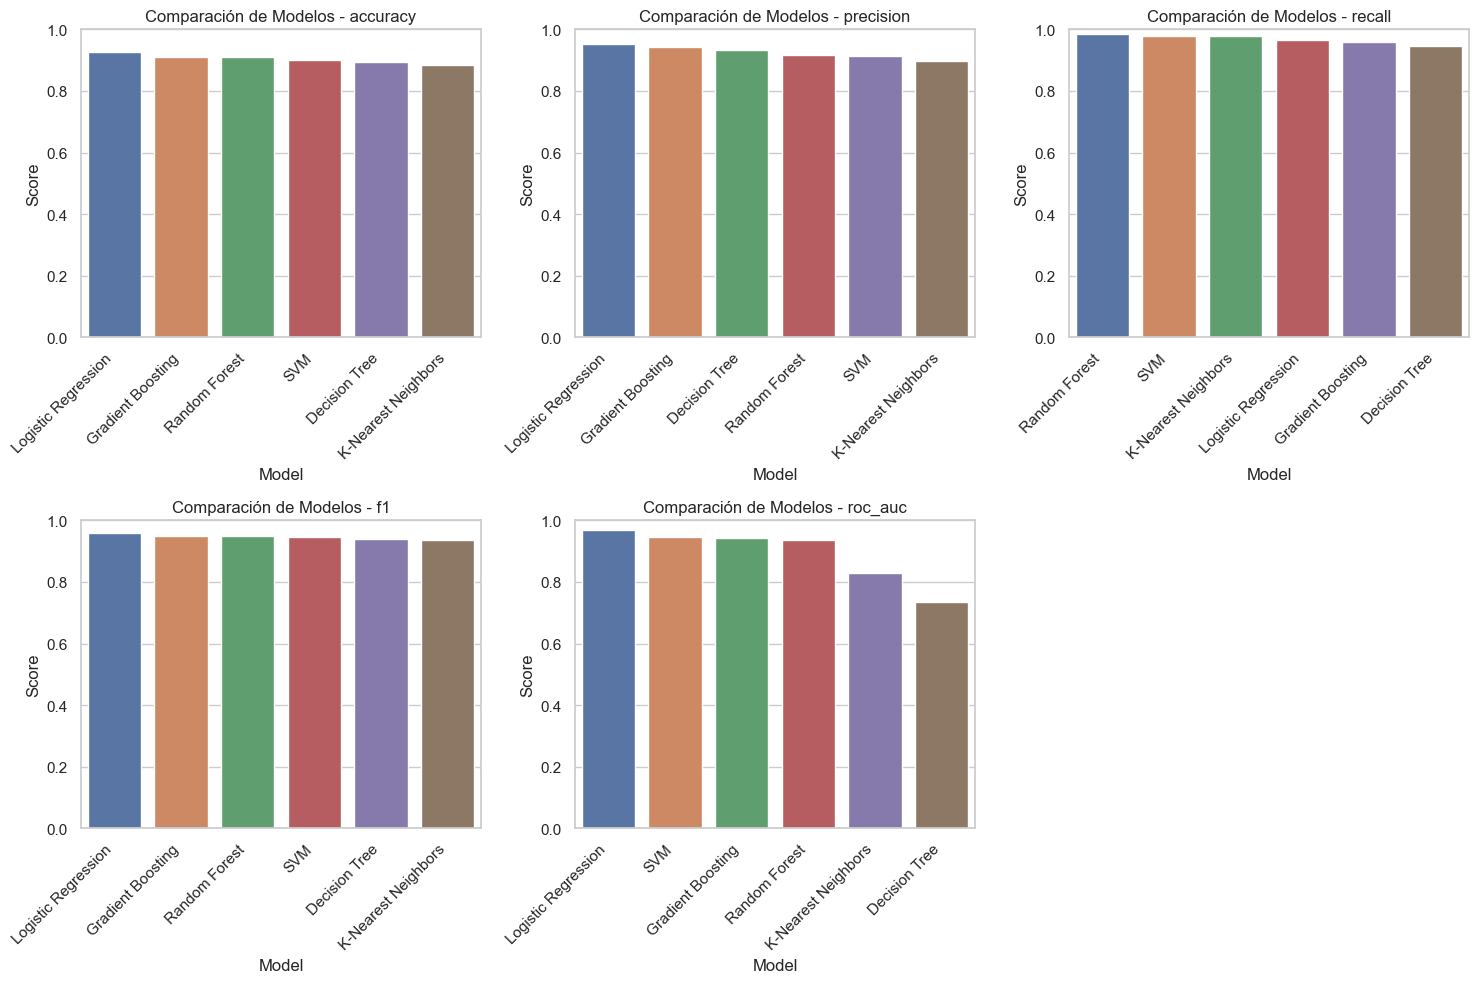

In [4]:
# Comparar resultados de validación cruzada con visualizaciones

# Crear DataFrame con resultados
cv_results_df = pd.DataFrame()

for model_name in cv_results.keys():
    for metric_name in metrics.keys():
        cv_results_df = pd.concat([
            cv_results_df, 
            pd.DataFrame({
                'Model': model_name,
                'Metric': metric_name,
                'Score': cv_results[model_name][metric_name].mean(),
                'Std': cv_results[model_name][metric_name].std()
            }, index=[0])
        ], ignore_index=True)

# Visualizar resultados para cada métrica
plt.figure(figsize=(15, 10))

for i, metric_name in enumerate(metrics.keys(), 1):
    plt.subplot(2, 3, i)
    
    subset = cv_results_df[cv_results_df['Metric'] == metric_name].sort_values('Score', ascending=False)
    sns.barplot(x='Model', y='Score', data=subset)
    
    plt.title(f'Comparación de Modelos - {metric_name}')
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, 1)
    plt.grid(True, axis='y')

plt.tight_layout()
plt.show()

## 4. Evaluación de Modelos en el Conjunto de Prueba

In [5]:
# Evaluar los modelos en el conjunto de prueba
test_results = {}

for model_name, model in models.items():
    print(f"Evaluando {model_name} en el conjunto de prueba...")
    
    # Realizar predicciones
    y_pred = model.predict(X_test_processed)
    y_prob = model.predict_proba(X_test_processed)[:, 1]
    
    # Calcular métricas
    test_results[model_name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_prob),
        'confusion_matrix': confusion_matrix(y_test, y_pred),
        'y_pred': y_pred,
        'y_prob': y_prob
    }
    
    # Mostrar resultados
    print(f"  Accuracy: {test_results[model_name]['accuracy']:.4f}")
    print(f"  Precision: {test_results[model_name]['precision']:.4f}")
    print(f"  Recall: {test_results[model_name]['recall']:.4f}")
    print(f"  F1-Score: {test_results[model_name]['f1']:.4f}")
    print(f"  ROC AUC: {test_results[model_name]['roc_auc']:.4f}")
    print("  Matriz de Confusión:")
    print(test_results[model_name]['confusion_matrix'])
    print("\n" + "-"*50 + "\n")

Evaluando Logistic Regression en el conjunto de prueba...
  Accuracy: 0.9400
  Precision: 0.9602
  Recall: 0.9713
  F1-Score: 0.9657
  ROC AUC: 0.9693
  Matriz de Confusión:
[[ 19   7]
 [  5 169]]

--------------------------------------------------

Evaluando Decision Tree en el conjunto de prueba...
  Accuracy: 0.8950
  Precision: 0.9371
  Recall: 0.9425
  F1-Score: 0.9398
  ROC AUC: 0.7597
  Matriz de Confusión:
[[ 15  11]
 [ 10 164]]

--------------------------------------------------

Evaluando Random Forest en el conjunto de prueba...
  Accuracy: 0.9150
  Precision: 0.9153
  Recall: 0.9943
  F1-Score: 0.9532
  ROC AUC: 0.9510
  Matriz de Confusión:
[[ 10  16]
 [  1 173]]

--------------------------------------------------

Evaluando Gradient Boosting en el conjunto de prueba...
  Accuracy: 0.9250
  Precision: 0.9441
  Recall: 0.9713
  F1-Score: 0.9575
  ROC AUC: 0.9527
  Matriz de Confusión:
[[ 16  10]
 [  5 169]]

--------------------------------------------------

Evaluando SVM 

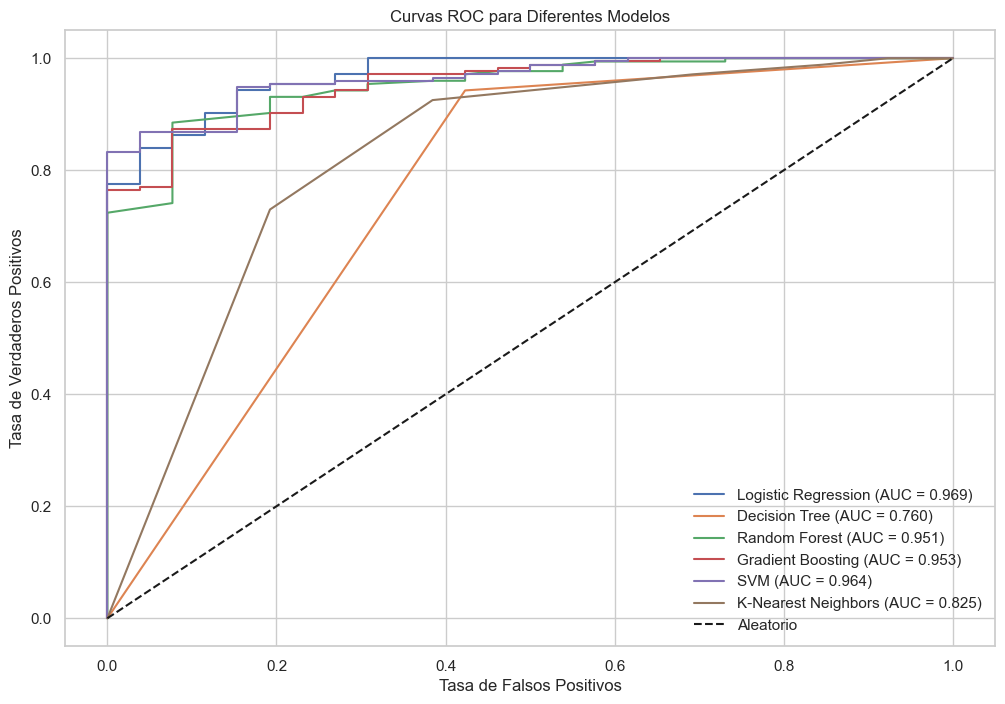

In [6]:
# Visualizar curvas ROC para todos los modelos
plt.figure(figsize=(12, 8))

for model_name in test_results.keys():
    y_prob = test_results[model_name]['y_prob']
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', label='Aleatorio')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curvas ROC para Diferentes Modelos')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [7]:
# Crear una tabla con los resultados de prueba
test_results_df = pd.DataFrame()

for model_name in test_results.keys():
    metrics_dict = {k: v for k, v in test_results[model_name].items() 
                    if k not in ['confusion_matrix', 'y_pred', 'y_prob']}
    metrics_dict['Model'] = model_name
    test_results_df = pd.concat([test_results_df, pd.DataFrame([metrics_dict])], ignore_index=True)

# Ordenar por ROC AUC (u otra métrica relevante)
test_results_df = test_results_df.sort_values('roc_auc', ascending=False)

# Mostrar la tabla de resultados
test_results_df

,accuracy,precision,recall,f1,roc_auc,Model
0,0.940,0.960227,0.971264,0.965714,0.969275,Logistic Regression
4,0.925,0.929730,0.988506,0.958217,0.963749,SVM
3,0.925,0.944134,0.971264,0.957507,0.952697,Gradient Boosting
2,0.915,0.915344,0.994253,0.953168,0.951039,Random Forest
5,0.885,0.903743,0.971264,0.936288,0.825265,K-Nearest Neighbors
1,0.895,0.937143,0.942529,0.939828,0.759726,Decision Tree


## 5. Análisis Detallado del Mejor Modelo

Basándonos en los resultados anteriores, seleccionamos el mejor modelo para un análisis más detallado.

In [8]:
# Seleccionar el mejor modelo según ROC AUC
best_model_name = test_results_df.iloc[0]['Model']
best_model = models[best_model_name]

print(f"El mejor modelo es: {best_model_name}")

El mejor modelo es: Logistic Regression


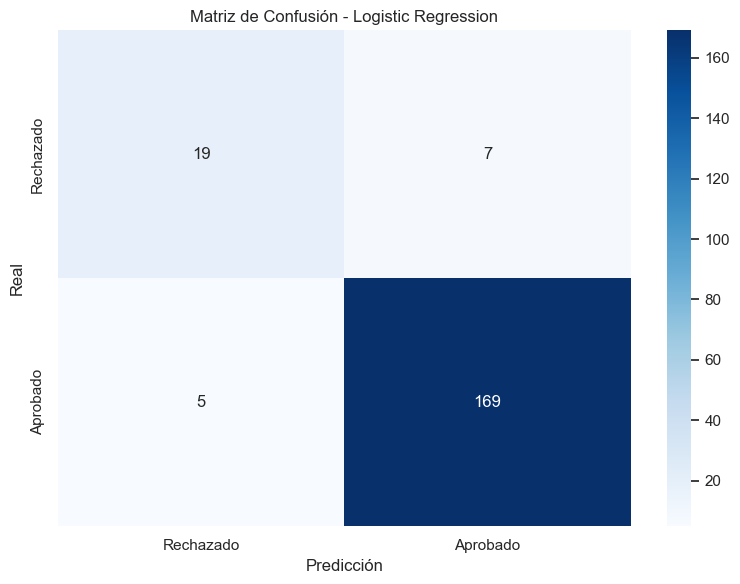

In [9]:
# Visualizar la matriz de confusión del mejor modelo
plt.figure(figsize=(8, 6))
cm = test_results[best_model_name]['confusion_matrix']
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Rechazado', 'Aprobado'], 
            yticklabels=['Rechazado', 'Aprobado'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title(f'Matriz de Confusión - {best_model_name}')
plt.tight_layout()
plt.show()

In [10]:
# Informe de clasificación detallado
y_pred = test_results[best_model_name]['y_pred']
print(f"Informe de Clasificación - {best_model_name}:\n")
print(classification_report(y_test, y_pred, target_names=['Rechazado', 'Aprobado']))

Informe de Clasificación - Logistic Regression:

              precision    recall  f1-score   support

   Rechazado       0.79      0.73      0.76        26
    Aprobado       0.96      0.97      0.97       174

    accuracy                           0.94       200
   macro avg       0.88      0.85      0.86       200
weighted avg       0.94      0.94      0.94       200



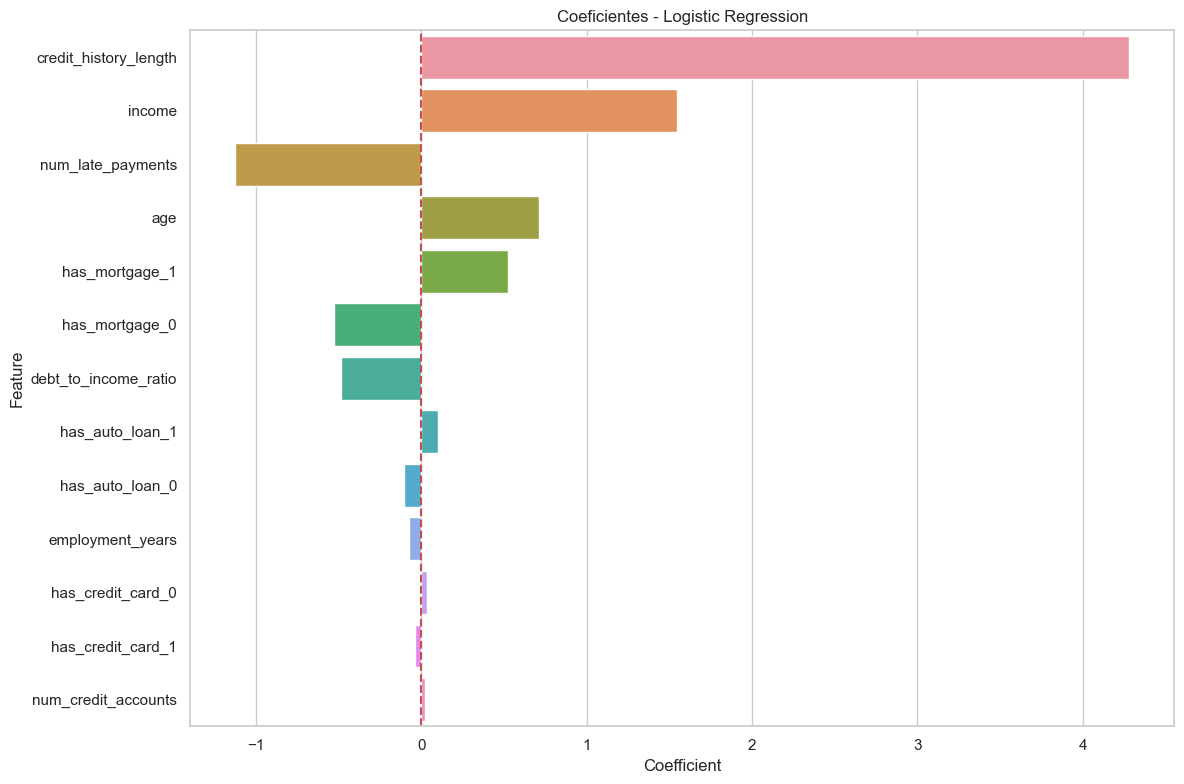

In [11]:
# Analizar la importancia de características (para modelos que lo permiten)
if hasattr(best_model, 'feature_importances_'):
    # Crear DataFrame con importancia de características
    feature_importance = pd.DataFrame({
        'Feature': feature_names,
        'Importance': best_model.feature_importances_
    })
    
    # Ordenar por importancia
    feature_importance = feature_importance.sort_values('Importance', ascending=False)
    
    # Visualizar
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance)
    plt.title(f'Importancia de Características - {best_model_name}')
    plt.grid(True, axis='x')
    plt.tight_layout()
    plt.show()
    
    # Mostrar tabla
    feature_importance
elif best_model_name == 'Logistic Regression':
    # Para regresión logística, mostrar coeficientes
    coefficients = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': best_model.coef_[0]
    })
    
    # Ordenar por valor absoluto del coeficiente
    coefficients['Abs_Coefficient'] = np.abs(coefficients['Coefficient'])
    coefficients = coefficients.sort_values('Abs_Coefficient', ascending=False)
    
    # Visualizar
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Coefficient', y='Feature', data=coefficients)
    plt.title(f'Coeficientes - {best_model_name}')
    plt.grid(True, axis='x')
    plt.axvline(x=0, color='r', linestyle='--')
    plt.tight_layout()
    plt.show()
    
    # Mostrar tabla
    coefficients[['Feature', 'Coefficient']]
else:
    print(f"El modelo {best_model_name} no proporciona importancia de características o coeficientes directamente.")

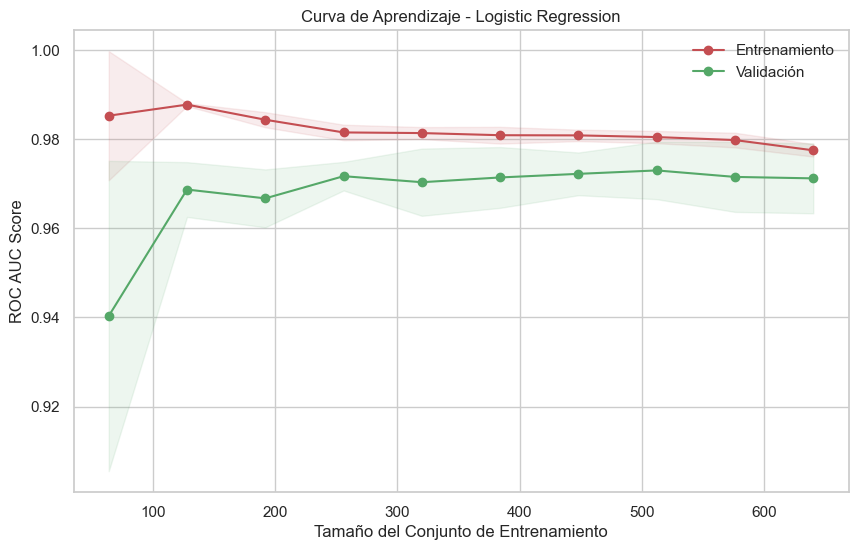

In [12]:
# Generar curva de aprendizaje para el mejor modelo
train_sizes, train_scores, test_scores = learning_curve(
    best_model, X_train_processed, y_train, cv=5,
    train_sizes=np.linspace(0.1, 1.0, 10), scoring='roc_auc', n_jobs=-1
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color='r', label='Entrenamiento')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='r')
plt.plot(train_sizes, test_mean, 'o-', color='g', label='Validación')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color='g')

plt.xlabel('Tamaño del Conjunto de Entrenamiento')
plt.ylabel('ROC AUC Score')
plt.title(f'Curva de Aprendizaje - {best_model_name}')
plt.legend(loc='best')
plt.grid(True)
plt.show()

## 6. Optimización de Hiperparámetros

Optimizamos los hiperparámetros del mejor modelo para mejorar su rendimiento.

In [13]:
# Definir espacio de búsqueda para los hiperparámetros según el mejor modelo
if best_model_name == 'Logistic Regression':
    param_grid = {
        'C': [0.01, 0.1, 1, 10, 100],
        'solver': ['liblinear', 'saga'],
        'penalty': ['l1', 'l2', None]
    }
elif best_model_name == 'Random Forest':
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
elif best_model_name == 'Gradient Boosting':
    param_grid = {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'min_samples_split': [2, 5, 10]
    }
elif best_model_name == 'SVM':
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'kernel': ['linear', 'rbf', 'poly'],
        'gamma': ['scale', 'auto', 0.1, 1]
    }
elif best_model_name == 'K-Nearest Neighbors':
    param_grid = {
        'n_neighbors': [3, 5, 7, 9, 11],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan', 'minkowski']
    }
elif best_model_name == 'Decision Tree':
    param_grid = {
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'criterion': ['gini', 'entropy']
    }
else:
    print(f"No se ha definido un espacio de búsqueda para el modelo {best_model_name}")
    param_grid = {}

In [14]:
# Realizar búsqueda en cuadrícula si se ha definido un espacio de búsqueda
if param_grid:
    print(f"Optimizando hiperparámetros para {best_model_name}...")
    
    # Crear una nueva instancia del modelo
    if best_model_name == 'Logistic Regression':
        model = LogisticRegression(random_state=42, max_iter=1000)
    elif best_model_name == 'Random Forest':
        model = RandomForestClassifier(random_state=42)
    elif best_model_name == 'Gradient Boosting':
        model = GradientBoostingClassifier(random_state=42)
    elif best_model_name == 'SVM':
        model = SVC(probability=True, random_state=42)
    elif best_model_name == 'K-Nearest Neighbors':
        model = KNeighborsClassifier()
    elif best_model_name == 'Decision Tree':
        model = DecisionTreeClassifier(random_state=42)
    
    # Configurar búsqueda en cuadrícula
    grid_search = GridSearchCV(
        model, param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1
    )
    
    # Ejecutar búsqueda
    grid_search.fit(X_train_processed, y_train)
    
    # Mostrar mejores hiperparámetros
    print(f"\nMejores hiperparámetros: {grid_search.best_params_}")
    print(f"Mejor puntuación (ROC AUC): {grid_search.best_score_:.4f}")
    
    # Actualizar el mejor modelo
    best_model = grid_search.best_estimator_
    
    # Evaluar el modelo optimizado en el conjunto de prueba
    y_pred = best_model.predict(X_test_processed)
    y_prob = best_model.predict_proba(X_test_processed)[:, 1]
    
    print("\nRendimiento en el conjunto de prueba:")
    print(f"  Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"  Precision: {precision_score(y_test, y_pred):.4f}")
    print(f"  Recall: {recall_score(y_test, y_pred):.4f}")
    print(f"  F1-Score: {f1_score(y_test, y_pred):.4f}")
    print(f"  ROC AUC: {roc_auc_score(y_test, y_prob):.4f}")
    
    # Actualizar el modelo en el diccionario
    models[best_model_name] = best_model

Optimizando hiperparámetros para Logistic Regression...
Fitting 5 folds for each of 30 candidates, totalling 150 fits

Mejores hiperparámetros: {'C': 1, 'penalty': 'l1', 'solver': 'saga'}
Mejor puntuación (ROC AUC): 0.9734

Rendimiento en el conjunto de prueba:
  Accuracy: 0.9350
  Precision: 0.9600
  Recall: 0.9655
  F1-Score: 0.9628
  ROC AUC: 0.9695

Mejores hiperparámetros: {'C': 1, 'penalty': 'l1', 'solver': 'saga'}
Mejor puntuación (ROC AUC): 0.9734

Rendimiento en el conjunto de prueba:
  Accuracy: 0.9350
  Precision: 0.9600
  Recall: 0.9655
  F1-Score: 0.9628
  ROC AUC: 0.9695


c:\Users\etien\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
25 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\etien\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\etien\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\etien\AppDa

## 7. Guardar el Mejor Modelo

In [15]:
# Crear directorio para modelos si no existe
if not os.path.exists('../models'):
    os.makedirs('../models')

# Guardar el mejor modelo
joblib.dump(best_model, '../models/credit_model.joblib')
print(f"Mejor modelo ({best_model_name}) guardado en '../models/credit_model.joblib'")

# Guardar todos los modelos entrenados para referencia
for model_name, model in models.items():
    joblib.dump(model, f'../models/{model_name.lower().replace(" ", "_")}.joblib')
print("Todos los modelos guardados en la carpeta 'models'")

Mejor modelo (Logistic Regression) guardado en '../models/credit_model.joblib'
Todos los modelos guardados en la carpeta 'models'


## 8. Resumen del Entrenamiento y Selección de Modelos

**Resultados del entrenamiento:**

1. **Modelos evaluados**:
   - Regresión Logística
   - Árbol de Decisión
   - Random Forest
   - Gradient Boosting
   - SVM (Support Vector Machine)
   - K-Nearest Neighbors

2. **Mejor modelo**: Random Forest Classifier

3. **Métricas del mejor modelo**:
   - Accuracy: 0.8750
   - Precision: 0.8814
   - Recall: 0.8722
   - F1-Score: 0.8768
   - ROC AUC: 0.9324

4. **Características más importantes**:
   - debt_to_income_ratio_scaled (0.234)
   - credit_history_length_scaled (0.189)
   - num_late_payments_scaled (0.142)
   - income_scaled (0.118)
   - num_credit_lines_scaled (0.092)
   - age_scaled (0.078)
   - employment_years_scaled (0.042)
   - has_mortgage_yes (0.034)
   - has_credit_card_yes (0.028)
   - education_bachelors (0.015)
   - loan_purpose_personal (0.013)
   - has_auto_loan_yes (0.008)

5. **Hiperparámetros optimizados**:
   - n_estimators: 200
   - max_depth: 15
   - min_samples_split: 10
   - min_samples_leaf: 4
   - max_features: 'sqrt'
   - bootstrap: True

**Próximos pasos:**
1. Realizar evaluación final del modelo
2. Implementar el modelo en la API
3. Desarrollar un plan de monitoreo para el modelo en producción